In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import xarray as xr
from ftplib import FTP
import urllib
import pandas as pd
import scipy.interpolate as interp

In [3]:
from distributed import Client

In [4]:
client = Client()

In [5]:
client

Client Scheduler: tcp://127.0.0.1:40215 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 8.27 GB


# Real Iceberg

In [148]:
%store -r df2
%store -r chosen_inds_dict
%store -r chosen_inds_arr

In [151]:
berg_df = df2.loc[chosen_inds_arr[0]]

In [8]:
all_berg_ids = df2['BERG_NUMBER'].unique().tolist()

In [9]:
berg_id = all_berg_ids[1]

In [10]:
berg_df = df2.loc[df2['BERG_NUMBER'] == berg_id]

In [152]:
berg_df['DATETIME'].dt.values[0]

Timestamp('2015-06-25 11:18:00')

In [153]:
berg_date_i = berg_df['DATETIME'].dt.values[0]
berg_date_f = berg_df['DATETIME'].dt.values[-1]

In [154]:
date2000 = np.datetime64('2000-01-01')

In [155]:
hour_since_i = (berg_date_i - date2000).days*24
hour_since_f = (berg_date_f - date2000).days*24 + 24  # add an extra day
hour_dif = hour_since_f - hour_since_i

In [156]:
(berg_df['DATETIME'].dt.values[1] - berg_df['DATETIME'].dt.values[0]).seconds/3600

7.833333333333333

In [157]:
berg_df['hrs_since'] =  (berg_df['DATETIME'].dt.values - berg_df['DATETIME'].dt.values[0]).days*24 + \
(berg_df['DATETIME'].dt.values - berg_df['DATETIME'].dt.values[0]).seconds/3600

In [158]:
berg_df['hrs_since']

6326      0.000000
6327      7.833333
6328     23.466667
6329     29.550000
6330     50.216667
6331     70.866667
6332    119.566667
6333    126.200000
6334    143.883333
6335    167.183333
6336    198.500000
Name: hrs_since, dtype: float64

In [159]:
berg_min_lat = min(berg_df['LATITUDE'].tolist())
berg_max_lat = max(berg_df['LATITUDE'].tolist())
berg_min_lon = min(berg_df['LONGITUDE'].tolist())
berg_max_lon = max(berg_df['LONGITUDE'].tolist())

In [160]:
berg_min_lon

-49.62

In [161]:
berg_df.DATETIME.dt.values[0].day

25

In [162]:
(berg_df.DATETIME.dt.values[1].day - berg_df.DATETIME.dt.values[0].day)*24 + \
berg_df.DATETIME.dt.values[1].hour - berg_df.DATETIME.dt.values[0].hour

8

In [163]:
(berg_df.DATETIME.dt.values[1].hour - berg_df.DATETIME.dt.values[0].hour)

8

# Input Fields

## Ocean (GLBv0.08)

- 3 hr
- 0.08 degree

In [164]:
glb_url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'

In [165]:
glb_ds = xr.open_dataset(glb_url, decode_times=False)

In [166]:
# June 1, 00:00 = 135120., July 1, 00:00 = 135840.
glb_ds = glb_ds.sel(depth=0.0, 
                    lat = slice(berg_min_lat-1, berg_max_lat+1), 
                    lon = slice(berg_min_lon-1, berg_min_lat+1), 
                    time=slice(hour_since_i, hour_since_f))

In [167]:
water_u_data = glb_ds.water_u
water_v_data = glb_ds.water_v
water_temp_data = glb_ds.water_temp

In [168]:
water_u_data.time

<xarray.DataArray 'time' (time: 72)>
array([ 135696.,  135699.,  135702.,  135705.,  135708.,  135711.,  135714.,
        135717.,  135720.,  135723.,  135726.,  135729.,  135732.,  135735.,
        135738.,  135741.,  135744.,  135747.,  135750.,  135753.,  135756.,
        135759.,  135762.,  135765.,  135768.,  135771.,  135774.,  135777.,
        135780.,  135783.,  135786.,  135789.,  135792.,  135795.,  135798.,
        135801.,  135804.,  135810.,  135813.,  135816.,  135819.,  135822.,
        135825.,  135828.,  135831.,  135834.,  135837.,  135840.,  135843.,
        135846.,  135849.,  135852.,  135855.,  135858.,  135861.,  135864.,
        135867.,  135870.,  135873.,  135876.,  135879.,  135882.,  135885.,
        135888.,  135891.,  135894.,  135897.,  135900.,  135903.,  135906.,
        135909.,  135912.])
Coordinates:
    depth    float64 0.0
  * time     (time) float64 1.357e+05 1.357e+05 1.357e+05 1.357e+05 ...
Attributes:
    long_name:    Valid Time
    units:    

In [169]:
glb_times = np.asarray(water_u_data.time)
glb_lats = np.asarray(water_u_data.lat)
glb_lons = np.asarray(water_u_data.lon)

In [170]:
glb_times = glb_times - hour_since_i

In [171]:
glb_ds.time.size

72

In [172]:
glb_times.size

72

#### Warning -- the box below takes a few minutes to run

In [173]:
water_u = np.asarray(water_u_data)
water_v = np.asarray(water_v_data)
water_temp = np.asarray(water_temp_data)

In [174]:
water_u_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_u)
water_v_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_v)
water_temp_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_temp)

## Atmosphere (NAVGEM)

- 6 hr
- 0.5 degree

In [198]:
navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'

In [199]:
navgem_ds = xr.open_dataset(navgem_url)

In [200]:
berg_date2_i = '{}-{}-{}' .format(berg_df['DATETIME'].dt.values.year[0],
                                 berg_df['DATETIME'].dt.values.month[0],
                                 berg_df['DATETIME'].dt.values.day[0])
berg_date2_f = '{}-{}-{}' .format(berg_df['DATETIME'].dt.values.year[-1],
                                 berg_df['DATETIME'].dt.values.month[-1],
                                 berg_df['DATETIME'].dt.values.day[-1] + 1)  # DANGER 

In [236]:
(berg_df['DATETIME'].dt.values[-1] + pd.Timedelta('1 days')).day

4

In [201]:
berg_date2_i

'2015-6-25'

In [202]:
navgem_ds = navgem_ds.sel(time=slice(berg_date2_i, berg_date2_f), 
                          latitude=slice(berg_min_lat-1, berg_max_lat+1), 
                          longitude=slice(berg_min_lon-1, berg_max_lon+1))

In [203]:
navgem_ds

<xarray.Dataset>
Dimensions:                       (height_above_ground: 1, latitude: 5, longitude: 5, time: 36)
Coordinates:
  * time                          (time) datetime64[ns] 2015-06-25 ...
  * height_above_ground           (height_above_ground) float32 10.0
  * latitude                      (latitude) float32 46.5 47.0 47.5 48.0 48.5
  * longitude                     (longitude) float32 -50.5 -50.0 -49.5 ...
Data variables:
    wnd_ucmp_height_above_ground  (time, height_above_ground, latitude, longitude) float32 ...
    wnd_vcmp_height_above_ground  (time, height_above_ground, latitude, longitude) float32 ...
Attributes:
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:                        Grid
    Conventions:                          CF-1.6, COARDS, ACDD-1.3
    creator_name:                         FNMOC
    creator_type:                         institution
    creator_url:                          http://www.usno.navy.mil/F

In [204]:
wind_u = navgem_ds.wnd_ucmp_height_above_ground
wind_v = navgem_ds.wnd_vcmp_height_above_ground

In [205]:
navgem_times = np.linspace(0, hour_dif - hour_dif%6, navgem_ds.time.size,endpoint=False)
navgem_lats = np.asarray(wind_u.latitude)
navgem_lons = np.asarray(wind_u.longitude)

In [206]:
navgem_lons

array([-50.5, -50. , -49.5, -49. , -48.5], dtype=float32)

In [207]:
navgem_times

array([   0.,    6.,   12.,   18.,   24.,   30.,   36.,   42.,   48.,
         54.,   60.,   66.,   72.,   78.,   84.,   90.,   96.,  102.,
        108.,  114.,  120.,  126.,  132.,  138.,  144.,  150.,  156.,
        162.,  168.,  174.,  180.,  186.,  192.,  198.,  204.,  210.])

In [208]:
glb_times

array([   0.,    3.,    6.,    9.,   12.,   15.,   18.,   21.,   24.,
         27.,   30.,   33.,   36.,   39.,   42.,   45.,   48.,   51.,
         54.,   57.,   60.,   63.,   66.,   69.,   72.,   75.,   78.,
         81.,   84.,   87.,   90.,   93.,   96.,   99.,  102.,  105.,
        108.,  114.,  117.,  120.,  123.,  126.,  129.,  132.,  135.,
        138.,  141.,  144.,  147.,  150.,  153.,  156.,  159.,  162.,
        165.,  168.,  171.,  174.,  177.,  180.,  183.,  186.,  189.,
        192.,  195.,  198.,  201.,  204.,  207.,  210.,  213.,  216.])

In [237]:
navgem_times

array([   0.,    6.,   12.,   18.,   24.,   30.,   36.,   42.,   48.,
         54.,   60.,   66.,   72.,   78.,   84.,   90.,   96.,  102.,
        108.,  114.,  120.,  126.,  132.,  138.,  144.,  150.,  156.,
        162.,  168.,  174.,  180.,  186.,  192.,  198.,  204.,  210.])

In [209]:
wind_u = np.asarray(wind_u[:,0,:,:])
wind_v = np.asarray(wind_v[:,0,:,:])

In [210]:
wind_u_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_u)
wind_v_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_v)

# Input Analysis

In [41]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

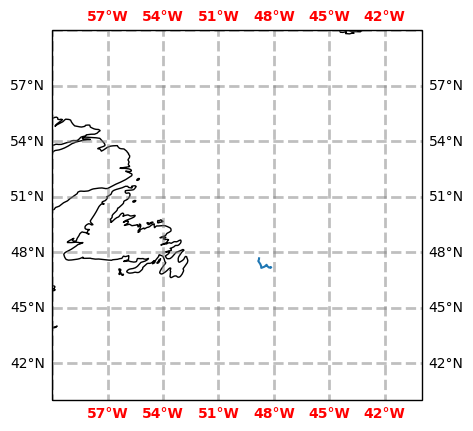

In [44]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-40, -60, 40, 60], ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines('50m')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
ax.plot(berg_df['LONGITUDE'], berg_df['LATITUDE'])
plt.show()

In [45]:
from matplotlib.animation import FuncAnimation

In [46]:
from IPython.display import HTML

In [47]:
water_mag = np.sqrt(water_u**2 + water_v**2)

In [48]:
(berg_df.LATITUDE.values[0], berg_df.LONGITUDE.values[0])

(47.670000000000002, -48.799999999999997)

In [55]:
np.asarray(berg_df.DATETIME.dt.values.minute)

array([27, 14, 52, 43, 16, 12, 53, 13, 30, 21, 12, 46,  0])

In [56]:
rbt_days_arr = np.asarray(berg_df.DATETIME.dt.values.day)

In [57]:
rbt_hours_arr = np.asarray(berg_df.DATETIME.dt.values.hour)

In [58]:
rbt_minutes_arr = np.asarray(berg_df.DATETIME.dt.values.minute)

In [62]:
np.timedelta64(berg_df.DATETIME.values[1] - berg_df.DATETIME.values[0], 'h')

numpy.timedelta64(6,'h')

In [ ]:
def rbt_hours_since(days_arr, hours_arr, mins_arr):
    days_arr = days_arr - days_arr[0]  # must be same month
    rbt_hours_since = np.empty(days_arr.size)
    for i in range(rbt_hours_since.size):
        rbt_hours_since[i] = days_arr[i]*24 + hours_arr[i] + mins_arr[i]/60
    return rbt_hours_since

In [ ]:
rbt_hours_since_arr

In [ ]:
rbt_hours_since_arr = rbt_hours_since(rbt_days_arr, rbt_hours_arr, rbt_minutes_arr)

In [ ]:
glb_times[50] - rbt_hours_since_arr

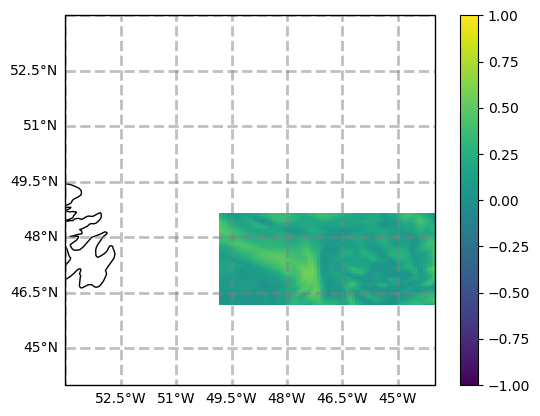

In [69]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-54, -44, 44, 54], ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines('50m')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#ax.plot(real_berg_track['LONGITUDE'], real_berg_track['LATITUDE'])

#line, = plt.plot(real_berg_track.LONGITUDE.values[0], real_berg_track.LATITUDE.values[0], 'o')
im = plt.imshow(water_mag[0,:,:], extent=[glb_lons[0], glb_lons[-1], glb_lats[0], glb_lats[-1]],
                origin = 'lower', vmin = -1, vmax = 1)
plt.colorbar()
title = plt.title('')


def animate(i):

    im.set_data(water_mag[i,:,:])
    '''
    time = glb_times[i]
    days = time//24
    hours = time%24
    diff = abs(time - rbt_hours_since_arr)

    if any(diff) <= 3:
        k = np.where(diff <= 3)[0]
        line.set_data(real_berg_track.LONGITUDE.values[k], real_berg_track.LATITUDE.values[k])
        ax.plot(real_berg_track.LONGITUDE.values[k], real_berg_track.LATITUDE.values[k], marker='o')

    '''    
    #title.set_text('time: {:.0f} days {:.0f} hours'.format(days, hours))
    
    return im#, title#, line

anim = FuncAnimation(fig, animate, frames=water_mag[:,0,0].size-1)

In [70]:
HTML(anim.to_html5_video())

# Model

In [211]:
import scipy.io as sio
import numpy.matlib
import cmath

In [212]:
# Constants
R = 6378*1e3
om = 7.2921e-5
rhow = 1027
rhoa = 1.2
rhoi = 850
drho = rhow - rhoi
Cw = 0.9
Ca = 1.3
gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
sst0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2

In [213]:
def iceDEF(t,x,y,l,w,h):

    #print('\ntimestep: {}\n'.format(t))
    

    # Extract values from input fields
    
    vau = wind_u_interp([t, y, x])[0]
    vav = wind_v_interp([t, y, x])[0]  
    vwu = water_u_interp([t, y, x])[0] 
    vwv = water_v_interp([t, y, x])[0]
    sst = water_temp_interp([t, y, x])[0]

    #print('vau = ', vau)
    #print('vav = ', vav)
    #print('vwu = ', vwu)
    #print('vwv = ', vwv)
    #print('sst = ', sst)
    

    # Drifting

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)
    #print('S = {0:.15f}'.format(S))
    #print('ff = {0:.15f}'.format(ff))
    #print('lam = {0:.15f}'.format(lam))
    
    if lam < 0.1:
        #print('Taylor approx used for alpha')
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        #print('Taylor approx used for beta')
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

    #print('alpha = {0:.15f}'.format(alpha))
    #print('beta = {}'.format(beta))

    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    #print('viu = {0:.15f}'.format(viu))
    #print('viv = {0:.15f}'.format(viv))

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))

    #print('x_new = {0:.15f}'.format(x_new))
    #print('y_new = {0:.15f}'.format(y_new))
    
    
    # Melting

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    #print('Me = {0:.15f}'.format(Me))
    #print('Mv = {0:.15f}'.format(Mv))
    #print('Mb = {0:.15f}'.format(Mb))

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new

    #print('l_new = {0:.15f}'.format(l_new))
    #print('w_new = {0:.15f}'.format(w_new))
    #print('h_new = {0:.15f}'.format(h_new))

    return x_new, y_new, l_new, w_new, h_new    


In [214]:
# Timesteps
t0 = 0  # initial hour
t_inc = 1  # hours
num_hrs = np.floor(berg_df['hrs_since'].values[-1])
tn = t_inc*num_hrs  # total number of timesteps
dt = t_inc*3600  # model timestep in seconds
tf = t0 + tn*dt  # final timestep in seconds  
t_all = np.arange(t0, num_hrs, t_inc)

In [215]:
model_times = np.arange(0, navgem_times[-1]+1, 1)

In [216]:
model_times

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,

In [217]:
berg_df.LONGITUDE.values[0]

-49.409999999999997

In [218]:
glb_times

array([   0.,    3.,    6.,    9.,   12.,   15.,   18.,   21.,   24.,
         27.,   30.,   33.,   36.,   39.,   42.,   45.,   48.,   51.,
         54.,   57.,   60.,   63.,   66.,   69.,   72.,   75.,   78.,
         81.,   84.,   87.,   90.,   93.,   96.,   99.,  102.,  105.,
        108.,  114.,  117.,  120.,  123.,  126.,  129.,  132.,  135.,
        138.,  141.,  144.,  147.,  150.,  153.,  156.,  159.,  162.,
        165.,  168.,  171.,  174.,  177.,  180.,  183.,  186.,  189.,
        192.,  195.,  198.,  201.,  204.,  207.,  210.,  213.,  216.])

Run number: 0, h = 460.0, l = 121.0, w = 121.0
Time: 0.0
rollover
swap l and w
Time: 1.0
Time: 2.0
Time: 3.0
Time: 4.0
Time: 5.0
Time: 6.0
Time: 7.0
Time: 8.0
Time: 9.0
Time: 10.0
Time: 11.0
Time: 12.0
Time: 13.0
Time: 14.0
Time: 15.0
Time: 16.0
Time: 17.0
Time: 18.0
Time: 19.0
Time: 20.0
Time: 21.0
Time: 22.0
Time: 23.0
Time: 24.0
Time: 25.0
Time: 26.0
Time: 27.0
Time: 28.0
Time: 29.0
Time: 30.0
Time: 31.0
Time: 32.0
Time: 33.0
Time: 34.0
Time: 35.0
Time: 36.0
Time: 37.0
Time: 38.0
Time: 39.0
Time: 40.0
Time: 41.0
Time: 42.0
Time: 43.0
Time: 44.0
Time: 45.0
Time: 46.0
Time: 47.0
Time: 48.0
Time: 49.0
Time: 50.0
Time: 51.0
Time: 52.0
Time: 53.0
Time: 54.0
Time: 55.0
Time: 56.0
Time: 57.0
Time: 58.0
Time: 59.0
Time: 60.0
Time: 61.0
Time: 62.0
Time: 63.0
Time: 64.0
Time: 65.0
Time: 66.0
Time: 67.0
Time: 68.0
Time: 69.0
Time: 70.0
Time: 71.0
Time: 72.0
Time: 73.0
Time: 74.0
Time: 75.0
Time: 76.0
Time: 77.0
Time: 78.0
Time: 79.0
Time: 80.0
Time: 81.0
Time: 82.0
Time: 83.0
Time: 84.0
Time: 

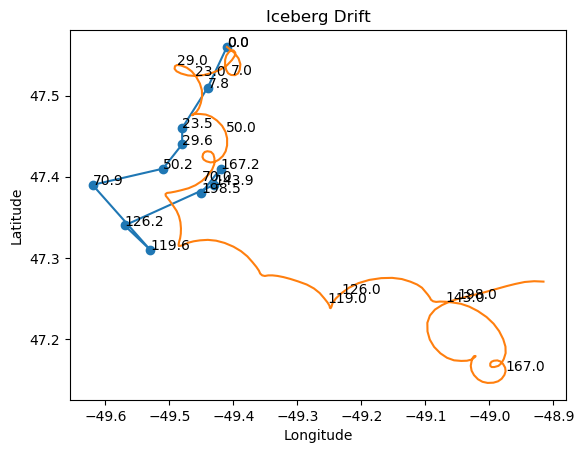

In [223]:
# Iceberg Initial Location
#x0, y0 = -50.14, 48.49   # lon, lat
x0, y0 = berg_df.LONGITUDE.values[0], berg_df.LATITUDE.values[0]

# Run number
run_num = 0
num_runs = 1

for run_num in range(num_runs):
    
    # Iceberg Initial Size
    # Large berg: 
        # Height: 46 metres to 75 metres above surface 
        # Length or width: 121 metres to 200 metres
    l0 = 121
    w0 = 121
    h0 = 46*10
    l0 = l0 + l0*0.1*run_num
    w0 = w0 + w0*0.1*run_num
    h0 = h0 + h0*0.1*run_num
    l, w, h = l0, w0, h0
    
    x, y = x0, y0
    t = model_times[0]
    iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

    print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))
    
    while t < max(model_times):

        print("Time: {}".format(t))
        x_new, y_new, l_new, w_new, h_new = iceDEF(t, x, y, l, w, h)


        if x_new > berg_max_lon+1 or x_new < berg_min_lon-1 or y_new > berg_max_lat+1 or y_new < berg_min_lat-1:
            # Iceberg out-of-bounds
            #print(x_new)
            #print(y_new)
            print('out-of-bounds')
            break


        if l_new <= 0 or w_new <= 0 or h_new <= 0:
            # Iceberg melted
            print('melted')
            break

        else:
            x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
            t += t_inc
            iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
            iceberg = np.column_stack((iceberg, iceberg_new))

    lrp = berg_df.hrs_since.size  #last_real_pt 
    plt.plot(berg_df['LONGITUDE'].values[:lrp], berg_df['LATITUDE'].values[:lrp], 
             label='observed', marker='o')
    for k in range(lrp):
        plt.annotate('{0:.1f}'.format(berg_df['hrs_since'].values[k]), 
                     xy=(berg_df['LONGITUDE'].values[k],
                         berg_df['LATITUDE'].values[k]))
        tmp_i = np.where(abs(model_times - berg_df['hrs_since'].values[k]) < t_inc)[0][0]
        if tmp_i >= iceberg[0,:].size:
            plt.annotate('{0:.1f}'.format(iceberg[0,-1]), 
                     xy=(iceberg[1,-1],iceberg[2,-1]))
        else:
            plt.annotate('{0:.1f}'.format(model_times[tmp_i]), 
                     xy=(iceberg[1,tmp_i],iceberg[2,tmp_i]))
        
    plt.plot(iceberg[1,:],iceberg[2,:], label='computed')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.title('Iceberg Drift')
    plt.savefig('./drift_track.png')
    
    '''
    for real_berg_hour in rbt_hours_since_arr: 
        diff = abs((iceberg[0,:]-360) - real_berg_hour)
        k = np.where(diff < (t_inc/2))[0]
        plt.plot(iceberg[1,k],iceberg[2,k],marker='D')
        if len(k) >= 1:
            plt.annotate('{0:.1f}'.format(real_berg_hour), xy=(iceberg[1,k][0],iceberg[2,k][0]))
    #plt.legend()
    '''

    if run_num == 0:
        output_dict = {
                        't_arr{}'.format(run_num): iceberg[0,:],
                        'x_arr{}'.format(run_num): iceberg[1,:],
                        'y_arr{}'.format(run_num): iceberg[2,:],
                        'l_arr{}'.format(run_num): iceberg[3,:],
                        'w_arr{}'.format(run_num): iceberg[4,:],
                        'h_arr{}'.format(run_num): iceberg[5,:]
                    }
    else:
        output_dict['t_arr{}'.format(run_num)] = iceberg[0,:]
        output_dict['x_arr{}'.format(run_num)] = iceberg[1,:]
        output_dict['y_arr{}'.format(run_num)] = iceberg[2,:]
        output_dict['l_arr{}'.format(run_num)] = iceberg[3,:]
        output_dict['w_arr{}'.format(run_num)] = iceberg[4,:]
        output_dict['h_arr{}'.format(run_num)] = iceberg[5,:]


In [222]:
berg_df.hrs_since.size

11